# Sentiment Analysis

## Setting the environment

In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting toolkit folder as working directory

%cd /content/drive/MyDrive/Project
! ls

/content/drive/MyDrive/Project
'Stock pr data'  'Stock raw data'  'Tweet pr data'  'Tweet raw data'


In [2]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\spenc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Loading dataset

In [ ]:
# Importing IMDb Movie Reviews dataset
%cd /content/drive/MyDrive/Project/Tweet pr data
reviews = pd.read_csv("Dataset.csv")



[Errno 2] No such file or directory: '/content/drive/MyDrive/Project/Tweet pr data'
/content


NameError: ignored

In [ ]:
# Dataset exploration

reviews.shape

(50000, 2)

In [ ]:
reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Checking for missing values

reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

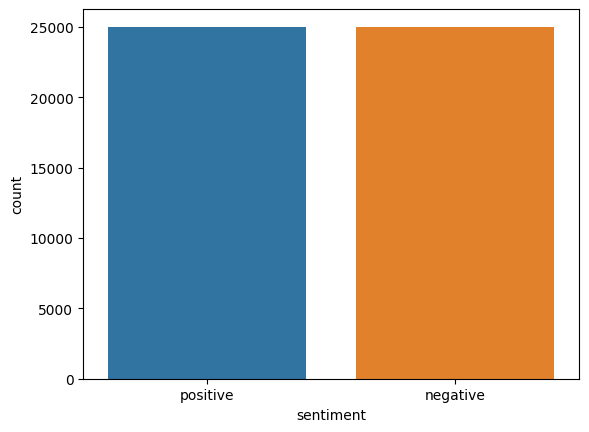

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=reviews)

## Data Preprocessing

In [ ]:
reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    # Remove rt
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Special char
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)



    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
# Converting sentiment labels to 0 & 1

y = reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=1, validation_split=0.2)

Epoch 1/12
250/250 [==============================] - 2s 7ms/step - loss: 0.5586 - acc: 0.7124 - val_loss: 0.5370 - val_acc: 0.7379
Epoch 2/12
250/250 [==============================] - 1s 5ms/step - loss: 0.4491 - acc: 0.7934 - val_loss: 0.5264 - val_acc: 0.7502
Epoch 3/12
250/250 [==============================] - 1s 6ms/step - loss: 0.4156 - acc: 0.8145 - val_loss: 0.5008 - val_acc: 0.7650
Epoch 4/12
250/250 [==============================] - 1s 6ms/step - loss: 0.3884 - acc: 0.8291 - val_loss: 0.5087 - val_acc: 0.7615
Epoch 5/12
250/250 [==============================] - 2s 9ms/step - loss: 0.3761 - acc: 0.8332 - val_loss: 0.5192 - val_acc: 0.7594
Epoch 6/12
250/250 [==============================] - 2s 10ms/step - loss: 0.3621 - acc: 0.8429 - val_loss: 0.5306 - val_acc: 0.7548
Epoch 7/12
250/250 [==============================] - 1s 6ms/step - loss: 0.3547 - acc: 0.8470 - val_loss: 0.5611 - val_acc: 0.7471
Epoch 8/12
250/250 [==============================] - 2s 6ms/step - loss: 0

In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.6329 - acc: 0.7392


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.632905900478363
Test Accuracy: 0.7391999959945679


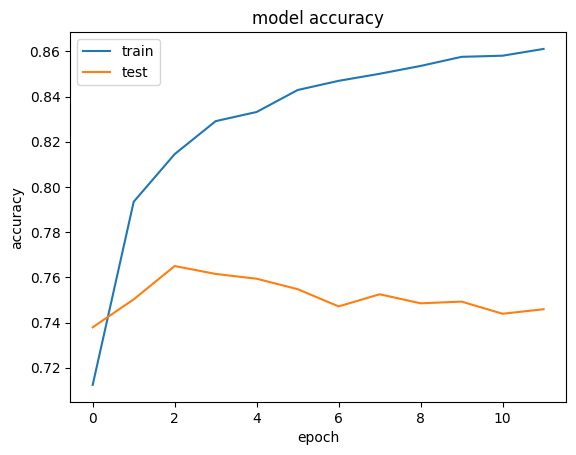

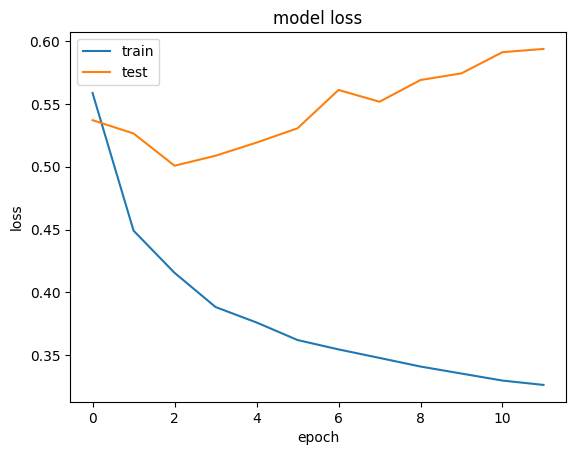

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 31s 120ms/step - loss: 0.4735 - acc: 0.7690 - val_loss: 0.3847 - val_acc: 0.8313
Epoch 2/10
250/250 [==============================] - 30s 118ms/step - loss: 0.3452 - acc: 0.8507 - val_loss: 0.3574 - val_acc: 0.8439
Epoch 3/10
250/250 [==============================] - 28s 112ms/step - loss: 0.2891 - acc: 0.8827 - val_loss: 0.3418 - val_acc: 0.8497
Epoch 4/10
250/250 [==============================] - 30s 118ms/step - loss: 0.2440 - acc: 0.9068 - val_loss: 0.3313 - val_acc: 0.8535
Epoch 5/10
250/250 [==============================] - 29s 118ms/step - loss: 0.2050 - acc: 0.9279 - val_loss: 0.3433 - val_acc: 0.8515
Epoch 6/10
250/250 [==============================] - 28s 111ms/step - loss: 0.1677 - acc: 0.9490 - val_loss: 0.3407 - val_acc: 0.8505
Epoch 7/10
250/250 [==============================] - 27s 109ms/step - loss: 0.1348 - acc: 0.9666 - val_loss: 0.3402 - val_acc: 0.8541
Epoch 8/10
250/250 [==============================] - 2

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 11ms/step - loss: 0.3786 - acc: 0.8501


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37856897711753845
Test Accuracy: 0.8500999808311462


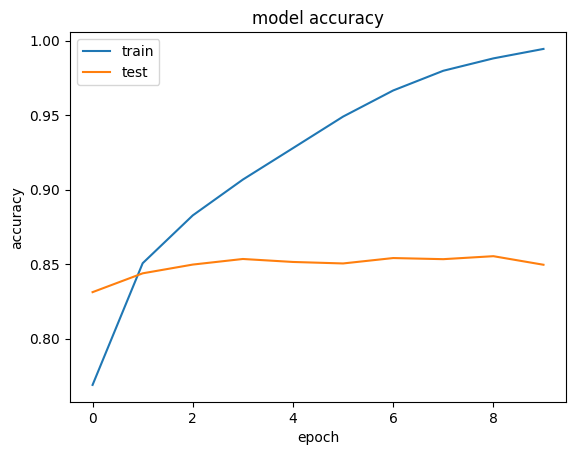

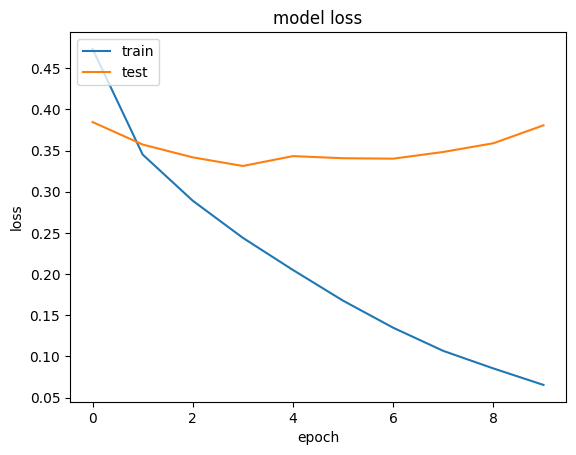

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
250/250 [==============================] - 96s 370ms/step - loss: 0.5262 - acc: 0.7420 - val_loss: 0.5018 - val_acc: 0.7768
Epoch 2/15
250/250 [==============================] - 91s 364ms/step - loss: 0.4269 - acc: 0.8090 - val_loss: 0.4154 - val_acc: 0.8254
Epoch 3/15
250/250 [==============================] - 96s 386ms/step - loss: 0.3868 - acc: 0.8300 - val_loss: 0.3537 - val_acc: 0.8472
Epoch 4/15
250/250 [==============================] - 95s 378ms/step - loss: 0.3477 - acc: 0.8508 - val_loss: 0.3529 - val_acc: 0.8558
Epoch 5/15
250/250 [==============================] - 92s 369ms/step - loss: 0.3280 - acc: 0.8606 - val_loss: 0.3328 - val_acc: 0.8575
Epoch 6/15
250/250 [==============================] - 93s 371ms/step - loss: 0.3147 - acc: 0.8701 - val_loss: 0.3152 - val_acc: 0.8649
Epoch 7/15
250/250 [==============================] - 95s 379ms/step - loss: 0.2920 - acc: 0.8816 - val_loss: 0.3101 - val_acc: 0.8643
Epoch 8/15
250/250 [==============================] - 9

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 23s 74ms/step - loss: 0.4325 - acc: 0.8612


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.43250101804733276
Test Accuracy: 0.8611999750137329


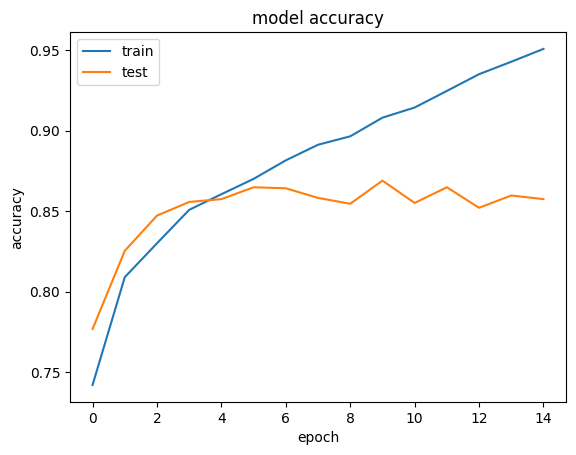

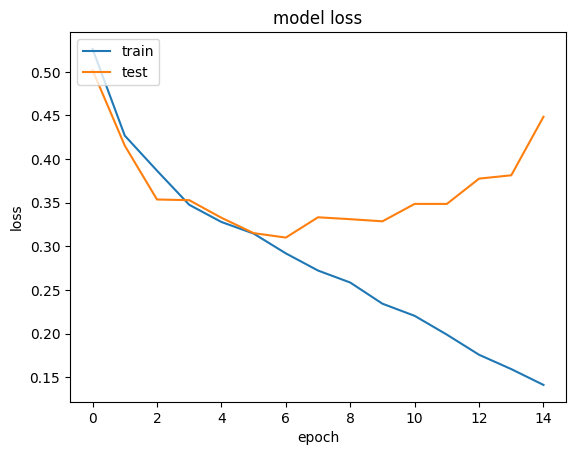

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./lstm_model{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Twitter data

In [ ]:
%cd /content/drive/MyDrive/Project/Tweet pr data
! ls  # lists files in working directory

/content/drive/MyDrive/Project/Tweet pr data
 a3_IMDb_Unseen_Reviews.csv		  Dataset.csv
 c1_lstm_model_acc_0.857.h5		  glove.txt
 c2_IMDb_Unseen_Predictions.csv		  lstm_model0.853.h5
'c2_sentimentanalysis_output(1).csv'	  lstm_model0.861.h5
'c2_sentimentanalysis_output(1).gsheet'   lstm_model_acc_0.857.h5
 c2_sentimentanalysis_output.csv	  tweet_data.csv


In [ ]:
#  Load previously trained LSTM Model

from keras.models import load_model

model_path ='./c1_lstm_model_acc_0.857.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_text = pd.read_csv("c2_sentimentanalysis_output.csv")

sample_text.head(6)

,text,sentiment
0,#Apple is eyeing a September 7 launch date for...,neutral
1,The latest Apple Watch Daily News! https://t.c...,neutral
2,C$19.99 - #FreeShipping | Super sale means sup...,positive
3,Vietnam to make Apple Watch and MacBook for fi...,neutral
4,When you need to write Unit Tests but long wee...,positive
5,iPhone Price Comparison https://t.co/yYf3dmB4W...,neutral


In [ ]:
sample_text['text'][0]

'#Apple is eyeing a September 7 launch date for its new iPhone 14!\nhttps://t.co/tcuKFXiPPK'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(text):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    unseen_text = text.lower()

    # Remove html tags
    unseen_text = remove_tags(unseen_text)

    # Remove punctuations and numbers
    unseen_text = re.sub('[^a-zA-Z]', ' ', unseen_text)

    # Single character removal
    unseen_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', unseen_text)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    unseen_text = re.sub(r'\s+', ' ', unseen_text)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    unseen_text = pattern.sub('', unseen_text)

    # Remove rt
    unseen_text = re.sub('RT @\w+: '," ", unseen_text)

    # Special char
    unseen_text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", unseen_text)

    #Remove Url
    unseen_text = re.sub(r"http\S+", '', unseen_text)



    return unseen_text

In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_processed = []
unseen_text = list(sample_text['text'])
for text in unseen_text:
  #text = preprocess_text(text)
  unseen_processed.append(preprocess_text(text))

In [ ]:
unseen_processed[0]

' apple eyeing september launch date new iphone  co tcukfxippk'

In [ ]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    word_tokenizer = pickle.load(handle)

In [ ]:
# Tokenising instance with earlier trained tokeniser
#word_tokenizer = Tokenizer()
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_tokenized

[[7095, 42866, 5320, 7230, 1138, 71, 88666, 883],
 [2221, 7095, 27, 2720, 1316, 883, 12656, 7095],
 [2825,
  1025,
  5710,
  660,
  1025,
  16215,
  52,
  247,
  14521,
  10984,
  7095,
  883,
  9952,
  3547,
  2529,
  1973,
  7095,
  52,
  10984,
  19,
  5915,
  14521,
  883],
 [2284, 21, 7095, 27, 19, 6, 42, 220, 4118, 883, 2284, 7095, 2110, 883],
 [237, 747, 4362, 9031, 90, 2331, 7096, 37014, 7095, 883],
 [88666, 1591, 1763, 883, 56775, 7095, 88666, 1805, 6328, 883, 15664],
 [2467,
  520,
  970,
  7095,
  1629,
  482,
  240,
  56261,
  31973,
  551,
  12512,
  6674,
  13643,
  883],
 [5965, 757, 47, 122, 531, 883, 324, 2784, 35, 757, 7095, 883],
 [7095,
  4834,
  2304,
  22166,
  35761,
  3911,
  31,
  71,
  1485,
  141,
  41184,
  6806,
  3411,
  56,
  9867,
  6149,
  220,
  883],
 [44081,
  3098,
  2307,
  3327,
  39,
  44,
  65400,
  4768,
  33000,
  883,
  11785,
  7095,
  31640,
  58603,
  14035,
  11539,
  65400],
 [7095,
  8085,
  3054,
  38285,
  15746,
  5932,
  3858,
  710

In [ ]:
# Pooling instance to have maxlength of 100 tokens
maxlen = 100
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
unseen_padded

array([[ 7095, 42866,  5320, ...,     0,     0,     0],
       [ 2221,  7095,    27, ...,     0,     0,     0],
       [ 2825,  1025,  5710, ...,     0,     0,     0],
       ...,
       [  924,  3142,  4005, ...,     0,     0,     0],
       [ 8163,  7334,  4307, ...,     0,     0,     0],
       [51303,  7095,  4834, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

32/32 [==============================] - 1s 30ms/step


array([[0.99604094],
       [0.99773556],
       [0.02553097],
       [0.9972325 ],
       [0.9972164 ],
       [0.22650169],
       [0.02601771],
       [0.9909598 ],
       [0.9967411 ],
       [0.99440694],
       [0.99777496],
       [0.13557206],
       [0.03570729],
       [0.934798  ],
       [0.0266367 ],
       [0.02526821],
       [0.02524914],
       [0.02996237],
       [0.03240022],
       [0.9976934 ],
       [0.02541452],
       [0.9976545 ],
       [0.9976729 ],
       [0.972776  ],
       [0.03012092],
       [0.99760574],
       [0.9971912 ],
       [0.83141494],
       [0.02555726],
       [0.02580455],
       [0.9973172 ],
       [0.02572165],
       [0.99579686],
       [0.9976289 ],
       [0.93010867],
       [0.9881053 ],
       [0.02552259],
       [0.03367651],
       [0.99420816],
       [0.9977516 ],
       [0.9976815 ],
       [0.99710643],
       [0.9963389 ],
       [0.9963544 ],
       [0.03071367],
       [0.02566532],
       [0.02541237],
       [0.992

In [ ]:
# Writing model output file back to Google Drive

sample_text['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_text['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_review_text           = pd.DataFrame(sample_text['text'], columns = ['text'])



dfx=pd.concat([df_review_text, df_prediction_sentiments], axis=1)

dfx.to_csv("./demo.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,text,Predicted Sentiments
0,#Apple is eyeing a September 7 launch date for...,10.0
1,The latest Apple Watch Daily News! https://t.c...,10.0
2,C$19.99 - #FreeShipping | Super sale means sup...,0.3
3,Vietnam to make Apple Watch and MacBook for fi...,10.0
4,When you need to write Unit Tests but long wee...,10.0
5,iPhone Price Comparison https://t.co/yYf3dmB4W...,2.3
